EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-256,Sketch:8*512
Execution time: 533.795 seconds.
Top_list with 33656 bytes.
Sketch with 16960 bytes.
Total size 49.4296875 kbytes, 
Find:36
Top_ARE: 0.4909
Top_AAE: 19806.8333
Estimate time:  0.368 seconds.

For copy:
Execution time: 533.795 seconds.
Top-225,CMS:8*512
Top_list with 33656 bytes.
Sketch with 16960 bytes.
Total size 49.4296875 kbytes, 
Find 0.667 of Heavy Hitters
Top_ARE: 0.4909
Top_AAE: 19806.8333
Estimate time:  0.368 seconds.
seed:[2618543479, 3728422007, 3741560759, 4290566591, 2781064063, 2493363311, 2258964401, 3828068429]


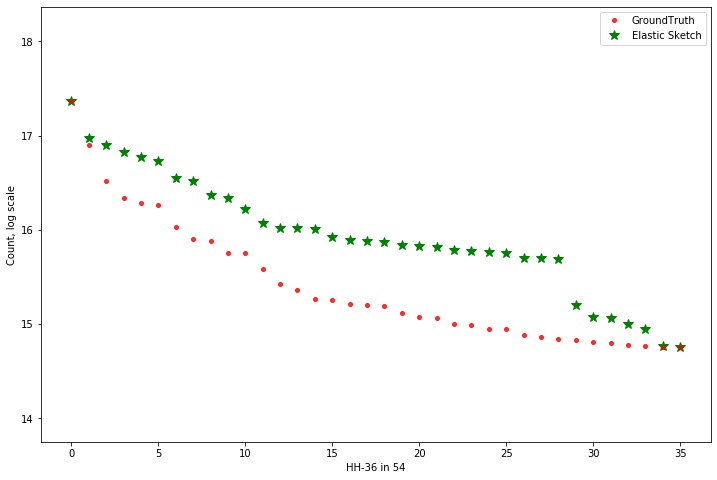

In [1]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=16
w=512
d=8
size=256
topk=256
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/1000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-256,Sketch:8*1024
Execution time: 472.909 seconds.
Top_list with 33536 bytes.
Sketch with 33344 bytes.
Total size 65.3125 kbytes, 
Find:40
Top_ARE: 0.2295
Top_AAE: 8513.1750
Estimate time:  0.359 seconds.

For copy:
Execution time: 472.909 seconds.
Top-95,CMS:8*1024
Top_list with 33536 bytes.
Sketch with 33344 bytes.
Total size 65.3125 kbytes, 
Find 0.741 of Heavy Hitters
Top_ARE: 0.2295
Top_AAE: 8513.1750
Estimate time:  0.359 seconds.
seed:[2684959633, 2241830347, 4229874911, 3540580691, 2817203083, 3163797911, 3846455897, 4290447713]


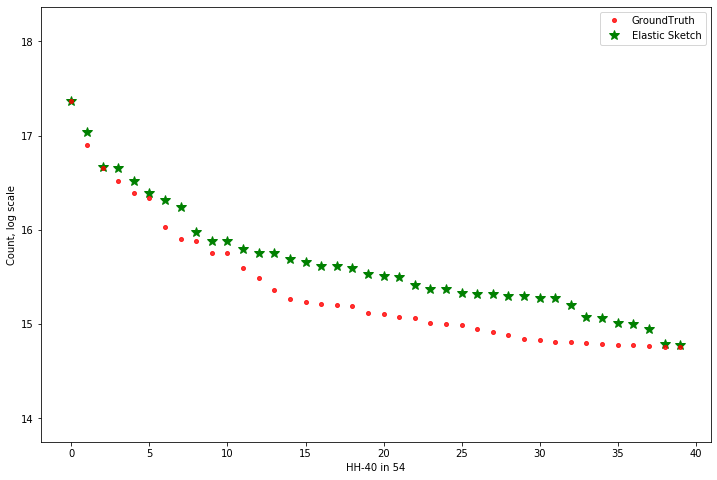

In [2]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=16
w=1024
d=8
size=256
topk=256
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/1000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top-{},CMS:{}*{}".format(len(HH),TC.depth,TC.width))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-1832,Sketch:8*1536
Execution time: 398.382 seconds.
Top_list with 240712 bytes.
Sketch with 49728 bytes.
Total size 283.6328125 kbytes, 
Find:49
Top_ARE: 0.0612
Top_AAE: 2258.7755
Estimate time:  0.385 seconds.

For copy:
Execution time: 398.382 seconds.
Top_list with 240712 bytes.
Sketch with 49728 bytes.
Total size 283.6328125 kbytes, 
Find 0.907 of Heavy Hitters
Top_ARE: 0.0612
Top_AAE: 2258.7755
Estimate time:  0.385 seconds.
seed:[2716117927, 3210371009, 4208719727, 3406360667, 2217824923, 3349489267, 4183796249, 2947607743]


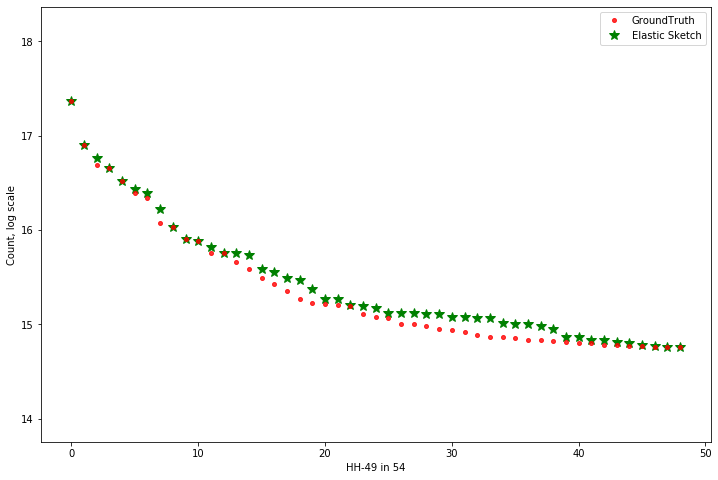

In [16]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=16
w=1536
d=8
size=1832
topk=1832
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/1000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_Top_'+str(TC.size)+'_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-2600,Sketch:8*1536
Execution time: 381.908 seconds.
Top_list with 341264 bytes.
Sketch with 49728 bytes.
Total size 381.828125 kbytes, 
Find:51
Top_ARE: 0.0591
Top_AAE: 2257.9608
Estimate time:  0.400 seconds.

For copy:
Execution time: 381.908 seconds.
Top_list with 341264 bytes.
Sketch with 49728 bytes.
Total size 381.828125 kbytes, 
Find 0.944 of Heavy Hitters
Top_ARE: 0.0591
Top_AAE: 2257.9608
Estimate time:  0.400 seconds.
seed:[3562965971, 2354945939, 2701554091, 3063694951, 2624030099, 2822863907, 3638055899, 3023970827]


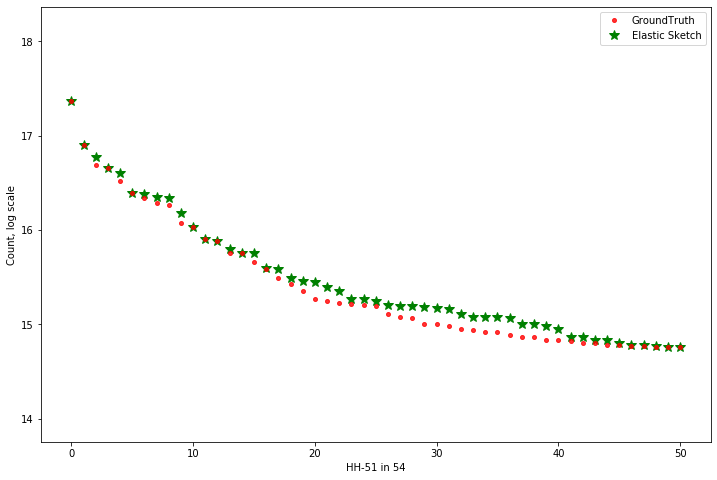

In [17]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=16
w=1536
d=8
size=2600
topk=2600
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/1000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_Top_'+str(TC.size)+'_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-3368,Sketch:8*1536
Execution time: 485.733 seconds.
Top_list with 442544 bytes.
Sketch with 49728 bytes.
Total size 480.734375 kbytes, 
Find:49
Top_ARE: 0.0554
Top_AAE: 2283.9184
Estimate time:  0.387 seconds.

For copy:
Execution time: 485.733 seconds.
Top_list with 442544 bytes.
Sketch with 49728 bytes.
Total size 480.734375 kbytes, 
Find 0.907 of Heavy Hitters
Top_ARE: 0.0554
Top_AAE: 2283.9184
Estimate time:  0.387 seconds.
seed:[2571177929, 2467825109, 3390826787, 2546812183, 3601906043, 3176003993, 3194108249, 2510367997]


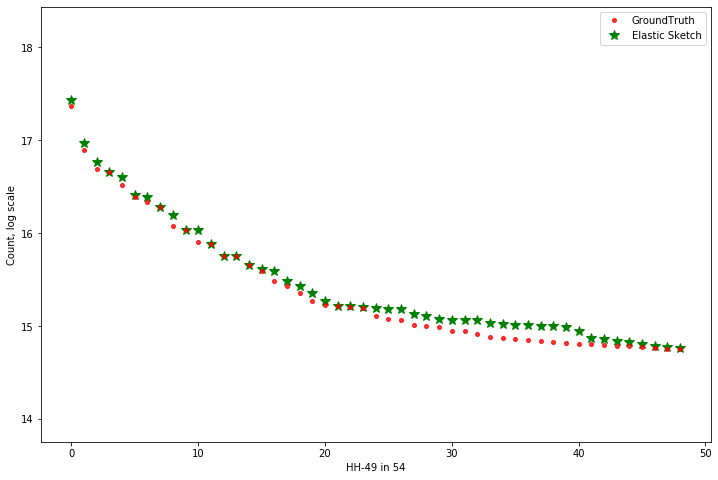

In [18]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=16
w=1536
d=8
size=3368
topk=3368
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/1000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_Top_'+str(TC.size)+'_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)


EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Top-1024,Sketch:8*1536
Execution time: 416.138 seconds.
Top_list with 134464 bytes.
Sketch with 49728 bytes.
Total size 179.875 kbytes, 
Find:52
Top_ARE: 0.1119
Top_AAE: 4415.6154
Estimate time:  0.374 seconds.

For copy:
Execution time: 416.138 seconds.
Top_list with 134464 bytes.
Sketch with 49728 bytes.
Total size 179.875 kbytes, 
Find 0.963 of Heavy Hitters
Top_ARE: 0.1119
Top_AAE: 4415.6154
Estimate time:  0.374 seconds.
seed:[2896186229, 3599437913, 3747818863, 3589769773, 3367845031, 2291040443, 3757860349, 3628809403]


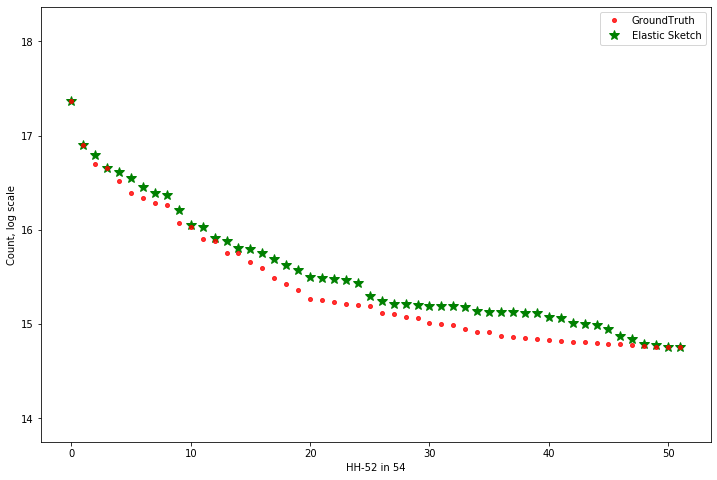

In [19]:
import sys
sys.path.append("..")

import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS
import numpy as np
import time
import os
import hyperloglog
from pympler import asizeof
import re

from cms.CountMinSketch import CountMinSketch

dataset='caida'
# =============================dataset path and file=============================
filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
threshold=8
w=1536
d=8
size=1024
topk=1024
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)    
Top=[None]*TC.size
total_count=0
heavy_ratio=1/1000

# =============================Stream processing=============================
item_count=True
start=time.time()
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while item_count:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                # =================read src ip field only===================
                index=TF.positionES(DS.Tail(e,1),1)
                    # one hash only              
                #print("index:{}".format(index))
                if Top[index]==None:
                    # bucket is empty
                    Top[index]=DS.esNode(e)
                else:
                    if Top[index].ID ==e:
                        # hit in Top
                        Top[index].vote_pos+=1
                    elif Top[index].ID !=e:
                        # e ollisions with e' at Top
                        Top[index].vote_neg+=1
                        vote_threshold=Top[index].vote_neg/Top[index].vote_pos
                        if vote_threshold<threshold:
                            # less than threshold: send (e,1) to CMS 
                            cms.Add_CMS(DS.Tail(e,1))
                        else:
                            # larger than threshold, evict e' to CMS and set (e,1,T,1)
                            cms.Add_CMS(DS.Tail(Top[index].ID,Top[index].vote_pos))
                            #cms.Add_CMS(e,Top[index].vote_pos)
                            Top[index]=DS.esNode(e,1,True,1)
end=time.time()

# =============================Print and Plot result=============================
#Topli=list(sorted(Top, key=lambda item: item.vote_pos,reverse=True))
    # sorted
print("Top-{},Sketch:{}*{}".format(size,d,w))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Memory usage
id_mem=0
flag_mem=0
votep_mem=0
voten_mem=0
for item in Top:
    id_mem+=asizeof.asizeof(item.ID)
    flag_mem+=asizeof.asizeof(item.vote_pos)
    votep_mem+=asizeof.asizeof(item.vote_neg)
    voten_mem=0    

heavy_mem=id_mem+flag_mem+votep_mem+voten_mem

sk0=heavy_mem
sk1=asizeof.asizeof(cms)
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))

# =============================heavy hitter from result=============================
HH=dict()
for item in Top:
    temp_count=TF.esQuery(item.ID,Top,cms)
    if temp_count>int(total_count*heavy_ratio):
        HH[item.ID]=temp_count

HH=dict(sorted(HH.items(), key=lambda item: item[1],reverse=True))

# =============================heavy hitter from ground truth=============================
# read ground truth
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]

gr_set=set(temp['Element'])
result=set(HH.keys())
tp_set=gr_set & result

# Count ARE/AAE
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,HH,tp_set)
print("Find:{}".format(len(tp_set)))
endx=time.time()
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(end-start))
print("Top_list with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} kbytes, ".format((sk0+sk1)/1024))
print("Find {:.3f} of Heavy Hitters".format(len(tp_set)/len(gr_set)))
print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 
print("seed:{}".format(TC.seed))

TF.Plot_hh_compare(temp,HH,"Elastic Sketch")

# =============================result to csv=============================
import pandas as pd
path="..\\result\\Ela\\"+dataset+"\\HH\\"+str(TC.depth)+"_"+str(TC.width)
# HH to csv
filename='Ela_HH_Top_'+str(TC.size)+'_'+str(len(gr_set))+'.csv'
topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)
